## PINN Model

In [5]:
import numpy as np

# Re-create the old alias that DeepXDE is expecting:
np.typeDict = np.sctypeDict

import os
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
import torch
import matplotlib.pyplot as plt


## Initialisations 

In [7]:
# Define the domain
x_min, x_max = -5, 5
t_min, t_max = 0, np.pi/2

# Create spatial and temporal 1D grids
x_vals = np.linspace(x_min, x_max, 200)
t_vals = np.linspace(t_min, t_max, 100)

# Make the 2D mesh
X_grid, T_grid = np.meshgrid(x_vals, t_vals)

# Flatten and stack into (N, 2)
X_flat = X_grid.ravel()[:, None]   # shape (20000, 1)
T_flat = T_grid.ravel()[:, None]   # shape (20000, 1)
x_test = np.hstack((X_flat, T_flat))  # shape (20000, 2)


## Domain Defination 

In [9]:
geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


## PDE, BC and IC Functions and Definations

In [10]:
# Define the PDE System
def pde(x,y):
    u=y[:, 0:1] #for the real part
    v=y[:, 1:2] # for the imaginary part
    
    # Derivatives 
    u_t=dde.grad.jacobian(y, x, i=0, j=1)
    v_t=dde.grad.jacobian(y,x, i=1, j=1)
    u_xx=dde.grad.hessian(y,x, component=0,i=0,j=0)
    v_xx=dde.grad.hessian(y,x, component=1, i=0, j=0)
    
    # Residuals
    f_u= u_t+0.5*v_xx+(u**2+v**2)*v
    f_v=-v_t+0.5*u_xx+(u**2+v**2)*u
    
    return[f_u, f_v]

In [29]:
# Define the intitial conditions 
def ic_u_value(x):
    # u(x,0) = 2 / cosh(x)
    return 2 / np.cosh(x[:, 0:1])
def ic_v_value(x):
    # v(x,0) = 0
    return np.zeros_like(x[:, 0:1])
# True at t = t_min (initial condition surface)
def on_initial(x, _):
    return np.isclose(x[1], t_min)

# True at x = x_min or x = x_max (spatial boundary)
def on_boundary(x, _):
    return np.isclose(x[0], x_min) or np.isclose(x[0], x_max)


## Periodic Boundary Condition

In [30]:
from deepxde import geometry, icbc
# periodic BC for u
bc_u   = icbc.PeriodicBC(geomtime, 0, on_boundary, component=0)
# periodic BC on ∂u/∂x
bc_u_x = icbc.PeriodicBC(geomtime, 0, on_boundary,
                         derivative_order=1, component=0)

# periodic BC for v
bc_v   = icbc.PeriodicBC(geomtime, 0, on_boundary, component=1)
# periodic BC on ∂v/∂x
bc_v_x = icbc.PeriodicBC(geomtime, 0, on_boundary,
                         derivative_order=1, component=1)

# initial condition for u at t=0
ic_u = icbc.IC(geomtime, ic_u_value, on_initial, component=0)
ic_v = icbc.IC(geomtime, ic_v_value, on_initial, component=1)


## Dataset Configuration

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,  # ← use the same name as your PDE function
    [ic_u, ic_v, bc_u, bc_u_x, bc_v, bc_v_x],  # ← note the comma here
    num_domain=5000,
    num_boundary=200,
    num_initial=200,
    # num_test=1000,  # ← optionally reserve points for testing
)


## Neural Network Configuration and Training


In [ ]:
# Define a neural network
layer_size = [2] + [100] * 4 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Create the model
model = dde.Model(data, net)
# Compile the model and optimizer with Adam
model.compile("adam", lr=0.001)
# Train the model for 5000 epochs
losshistory, train_state = model.train(epochs=5000)


Compiling model...
'compile' took 0.001645 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.56e-03, 8.95e-02, 1.15e+00, 7.76e-03, 2.43e+00, 4.15e-05, 1.11e-02, 4.73e-04]    [3.56e-03, 8.95e-02, 1.15e+00, 7.76e-03, 2.43e+00, 4.15e-05, 1.11e-02, 4.73e-04]    []  
1000      [1.34e-02, 1.36e-02, 2.21e-02, 2.28e-03, 1.42e-06, 3.07e-04, 2.66e-06, 1.12e-05]    [1.34e-02, 1.36e-02, 2.21e-02, 2.28e-03, 1.42e-06, 3.07e-04, 2.66e-06, 1.12e-05]    []  
2000      [9.50e-03, 9.20e-03, 1.53e-02, 7.60e-04, 1.06e-06, 5.57e-05, 9.83e-06, 2.45e-05]    [9.50e-03, 9.20e-03, 1.53e-02, 7.60e-04, 1.06e-06, 5.57e-05, 9.83e-06, 2.45e-05]    []  


## Model Refinement using L-BFGS Optimizer

In [54]:

model.compile("L-BFGS")
# Train until convergence (no need to pass iterations here)
losshistory_lbfgs, train_state_lbfgs = model.train()


Compiling model...
'compile' took 0.008393 s

Training model...

11014     [6.57e-06, 6.94e-06, 2.79e-06, 2.88e-07, 1.92e-08, 7.09e-08, 5.22e-08, 1.02e-07]    [6.57e-06, 6.94e-06, 2.79e-06, 2.88e-07, 1.92e-08, 7.09e-08, 5.22e-08, 1.02e-07]    []  


KeyboardInterrupt: 

## Post -Processing and Visualisations

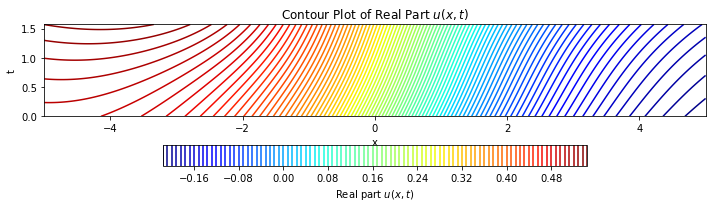

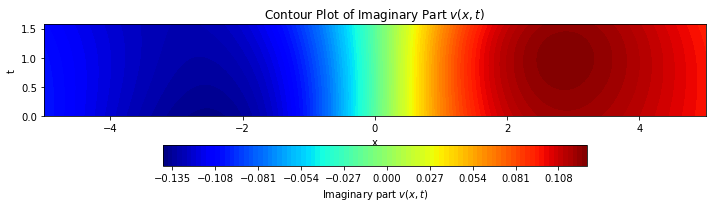

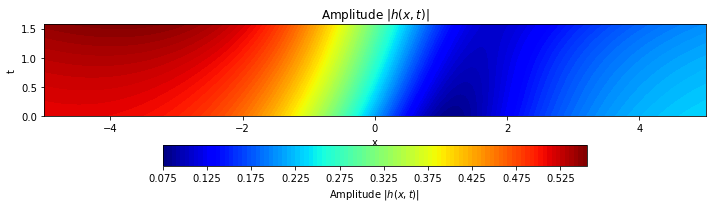

In [56]:
# Assuming you already have:
# X, T = np.meshgrid(x_vals, t_vals)
# u_pred, v_pred shaped (100, 200)

t_length = 10
x_length = 3

# Plot u(x,t) — real part
plt.figure(figsize=(t_length, x_length))
contour = plt.contour(x, T, u_pred, 100, cmap="jet")
cbar = plt.colorbar(contour, orientation="horizontal", pad=0.2)
cbar.set_label("Real part $u(x,t)$")
plt.title("Contour Plot of Real Part $u(x,t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(-5, 5)
plt.ylim(0, np.pi/2)
plt.tight_layout()
plt.show()

# Plot v(x,t) — “imaginary” part
plt.figure(figsize=(t_length, x_length))
contourf = plt.contourf(x, T, v_pred, 100, cmap="jet")
cbar = plt.colorbar(contourf, orientation="horizontal", pad=0.2)
cbar.set_label("Imaginary part $v(x,t)$")
plt.title("Contour Plot of Imaginary Part $v(x,t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(-5, 5)
plt.ylim(0, np.pi/2)
plt.tight_layout()
plt.show()

# Plot h(x,t) — amplitude
plt.figure(figsize=(t_length, x_length))
contourf = plt.contourf(x, T, h_pred, 100, cmap="jet")
cbar = plt.colorbar(contourf, orientation="horizontal", pad=0.2)
cbar.set_label("Amplitude $|h(x,t)|$")
plt.title("Amplitude $|h(x,t)|$")
# Axis labels and limits
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(-5, 5)
plt.ylim(0, np.pi/2)
plt.tight_layout()
plt.show()


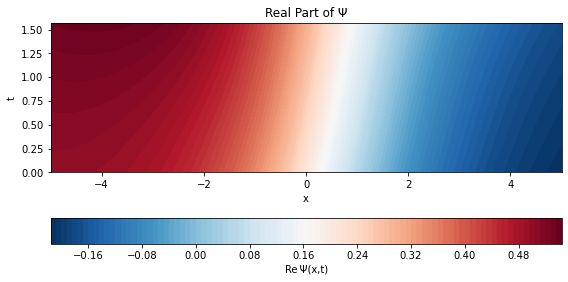

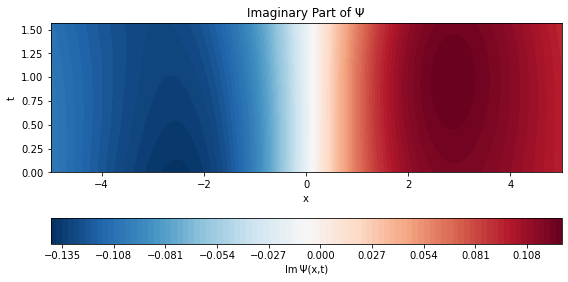

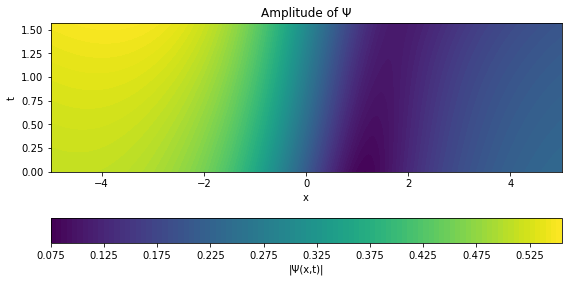

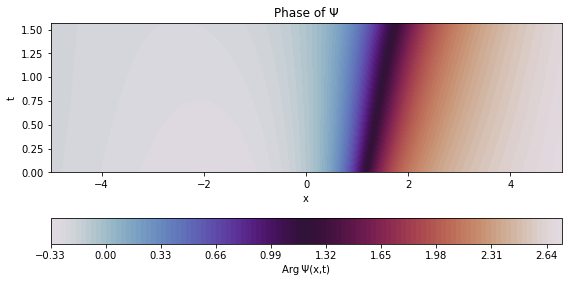

In [57]:

psi_pred   = u_pred + 1j * v_pred           # complex array
amp_pred   = np.abs(psi_pred)               # amplitude |Ψ|
phase_pred = np.angle(psi_pred)             # phase arg(Ψ) in (–π, π]

# Plot settings
figsize = (8, 4)    # width, height in inches
levels = 100

# 2) Real part of Ψ 
plt.figure(figsize=figsize)
cf = plt.contourf(x, T, psi_pred.real, levels, cmap="RdBu_r")
plt.colorbar(cf, orientation="horizontal", pad=0.2, label="Re Ψ(x,t)")
plt.title("Real Part of Ψ")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.tight_layout()
plt.show()

# 3) Imaginary part of Ψ
plt.figure(figsize=figsize)
cf = plt.contourf(x, T, psi_pred.imag, levels, cmap="RdBu_r")
plt.colorbar(cf, orientation="horizontal", pad=0.2, label="Im Ψ(x,t)")
plt.title("Imaginary Part of Ψ")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.tight_layout()
plt.show()

# 4) Amplitude |Ψ|
plt.figure(figsize=figsize)
cf = plt.contourf(x, T, amp_pred, levels, cmap="viridis")
plt.colorbar(cf, orientation="horizontal", pad=0.2, label="|Ψ(x,t)|")
plt.title("Amplitude of Ψ")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.tight_layout()
plt.show()

# 5) Phase arg Ψ
plt.figure(figsize=figsize)
cf = plt.contourf(x, T, phase_pred, levels, cmap="twilight")
plt.colorbar(cf, orientation="horizontal", pad=0.2, label="Arg Ψ(x,t)")
plt.title("Phase of Ψ")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(x_min, x_max)
plt.ylim(t_min, t_max)
plt.tight_layout()
plt.show()


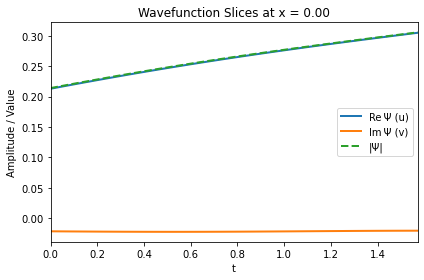

In [58]:
# Choose an x‐index
x_star = 0.0
idx_x = np.argmin(np.abs(x_vals - x_star))

# Extract u(t), v(t) at that x
u_slice_t = u_pred[:, idx_x]   # shape (Nt,)
v_slice_t = v_pred[:, idx_x]
amp_slice_t = np.sqrt(u_slice_t**2 + v_slice_t**2)

# Line plot in time
plt.figure(figsize=(6,4))
plt.plot(t_vals, u_slice_t, label="Re Ψ (u)", linewidth=2)
plt.plot(t_vals, v_slice_t, label="Im Ψ (v)", linewidth=2)
plt.plot(t_vals, amp_slice_t, "--", label="|Ψ|", linewidth=2)
plt.title(f"Wavefunction Slices at x = {x_star:.2f}")
plt.xlabel("t")
plt.ylabel("Amplitude / Value")
plt.xlim(t_min, t_max)
plt.legend()
plt.tight_layout()
plt.show()


# PINN solution Verification And Accuracy and Reability checks

## Govering Equations Residual Evaluation 